## ECE-UY 4563 Intro to Machine Learning Final Project - Dog Breed Classification 
* Presented by: Eren Tuksal(et2179@nyu.edu) and James Zhang(hz2852@nyu.edu)

In this project, we aim to develop a convolutional neural network capable of identifying 120 different dog breeds. The primary training dataset includes over 10,000 images of dogs captured from various angles and in diverse scenes. Additionally, there is a test dataset that includes not only dog images but also images of non-dog subjects, allowing us to evaluate the model's ability to differentiate between dog and non-dog images.

The following topics and techniques are covered:
* PyTorch
* Transfer Learning - resnet model is used


In [87]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import skimage
from sklearn import linear_model, preprocessing
from transformers import AutoImageProcessor, AutoModelForImageClassification

df = pd.read_csv('labels.csv')
print(df.head())
print(df.shape)
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18")
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-18")

                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever
(10222, 2)


* Part 1 - Check data
* Part 2 - Input images
* Part 3 - Image Augmentation

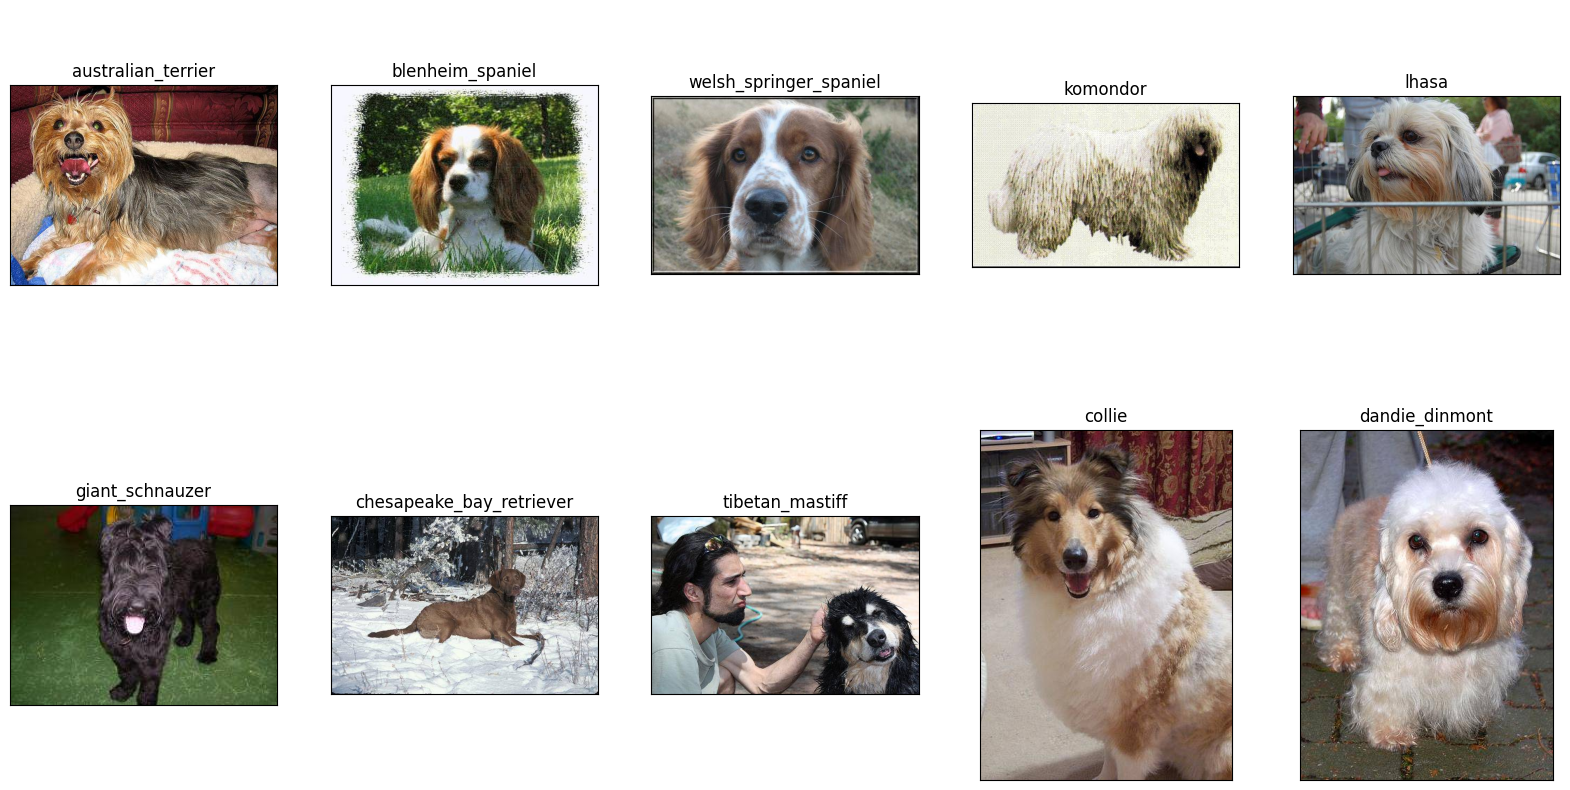

In [69]:
# display images function
def disp_image(im):
    # Color image.
    im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
    im1 = im1.astype(np.uint8)
    plt.imshow(im1)
    
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

plt.subplots(figsize=(20, 10))
plt.axis('off')
for i in range(10):
    plt.subplot(2, 5, i+1)
    k = np.random.randint(low=0,high=df.shape[0])
    fname = 'train/' + df['id'][k] + '.jpg'
    im_color = skimage.io.imread(fname)
    disp_image(im_color)
    plt.title(df.loc[k, 'breed'])


In [70]:
# Imgae preprocessing
# Convert dog breeds into numbers
le = preprocessing.LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])
df.head()

# Resize pictures
inputs = [] # a list of tensor for each image
for im in range(df.shape[0]):
    fname = 'train/' + df['id'][im] + '.jpg' 
    input_image = skimage.io.imread(fname)
    input_tensor = image_processor(input_image, return_tensors="pt") # dictionary with one key called 'pixel_values', which related to the tensor for image
    inputs.append(input_tensor["pixel_values"]) # append each tensor for an image to inputs
print(inputs[0].shape) # return the 1st tensor shape


torch.Size([1, 3, 224, 224])


In [71]:
# image_np = inputs[0].squeeze().permute(1, 2, 0).numpy()

# # Undo any normalization (if done during preprocessing) by adding back the ImageNet mean
# mean = [0.485, 0.456, 0.406]  # ImageNet mean
# std = [0.229, 0.224, 0.225]   # ImageNet std
# image_np = std * image_np + mean  # Undo normalization

# # # Clip values to be between 0 and 1 (for visualization purposes)
# # image_np = np.clip(image_np, 0, 1)

# # Display the image
# plt.imshow(image_np)
# plt.axis('off')  # Turn off axis labels
# plt.show()
labels = df['breed']
input_batch = torch.cat(inputs, dim=0)


In [72]:
print(labels.shape)
print(input_batch.shape)

(10222,)
torch.Size([10222, 3, 224, 224])


In [ ]:
## USE RESNET-18 to determine the breed
# part_labels = labels[19]
# part_inputs = inputs[19]
# with torch.no_grad():  # No need to compute gradients during inference
#     output = model(part_inputs)
#     logits = output.logits

# print(logits.shape)
# probabilities = torch.nn.functional.softmax(logits, dim=-1)

# # Find the top 3 classes and their probabilities
# ntop = 3
# top_prob, top_catid = torch.topk(probabilities, ntop)

# # Convert to numpy
# top_prob = top_prob.numpy()
# top_catid = top_catid.numpy()
# print(top_catid)
# id2label = model.config.id2label
# print(id2label[top_catid[0][0]])

torch.Size([1, 1000])
[[242 243 245]]
boxer


In [ ]:
# Modify the ResNet model
num_classes = 120
classifier = model.classifier[-1]  # Get the last layer (Linear)
# Modify the last Linear layer to have the desired number of output classes
model.classifier[-1] = nn.Linear(classifier.in_features, num_classes)
# print(model)

# freeze all layers except the last layer
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layer (the classifier head) so it can be trained
for param in model.classifier.parameters():
    param.requires_grad = True


In [99]:
from torch.utils.data import DataLoader, TensorDataset